In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import math as math
import pybinding as pb
from pybinding.repository import graphene
pb.pltutils.use_style()

In [2]:
a = 3*graphene.a_cc # lattice length.
a_cc = graphene.a_cc # carbon-carbon bond length
t = graphene.t # hopping energy of graphene.

#Topological -> 위상 기하적
#넓은것과 좁은것이 또 합쳐저서 하나의 unit cel이 됨.
#상태에 따라서 에너지나 property가 많이 달라짐.
# LAPACK -> exact diag . must in small system.


## Armchair Graphene

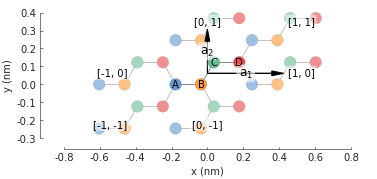

In [15]:
import math as math

def monolayer_graphene() :
    
    lat = pb.Lattice(a1=[a,0], a2 = [0,math.sqrt(3)*a_cc]) #lattice vector
    
    lat.add_sublattices(
        ('A',[-5/4*a_cc,0/4*a_cc]),
        ('B',[-1/4*a_cc,0/4*a_cc]),
        ('C',[1/4*a_cc,2*math.sqrt(3)/4*a_cc]),
        ('D',[5/4*a_cc,2*math.sqrt(3)/4*a_cc])
        )
                        
    lat.add_hoppings(
        ([0,0], 'A', 'B', t),
        ([0,0], 'B', 'C', t),
        ([0,0], 'C', 'D', t),
        ([-1,0],'A','D',t),
        ([0,-1],'B','C',t), 
        ([1,1],'D','A',t) 
    )
    
    return lat


lattice = monolayer_graphene()
lattice.plot()
plt.show()

## System

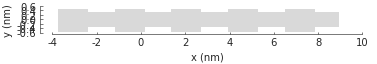

In [114]:
m = 0.001

leng = 6*a #lengh of supercell that I wanna make

def shape(T) : # T is the period of the shape
    rect = pb.rectangle(x=leng+m*50,y=9/2*math.sqrt(3)*a_cc) 
    rect_exc = pb.rectangle(x=3*a,y=1/2*math.sqrt(3)*a_cc) # rectangle that wil lbe excluded
   
    tr_rect = rect.with_offset([leng*(T-1),0])
    tr_rect_down = rect_exc.with_offset([2*a+leng*(T-1), -math.sqrt(3)*2*a_cc]) #3/2*a_cc
    tr_rect_up = rect_exc.with_offset([2*a+leng*(T-1), math.sqrt(3)*2*a_cc-m]) #3/2*a_cc
    shape_1 = tr_rect - tr_rect_down -tr_rect_up

    return shape_1

for i in range (0,5) :
    supercell += shape(i)
    
    
supercell.plot()
#arm_gra = pb.Model(lattice, shape())#,pb.translational_symmetry(a1=18*a_cc,a2=False))
#arm_gra.plot()
#arm_gra.shape.plot()

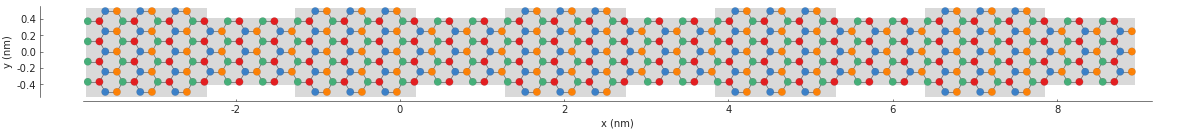

In [115]:
plt.figure(figsize=(20.7, 20.6))
arm_gra = pb.Model(lattice, supercell, pb.translational_symmetry(a1=18 ,a2=False))
arm_gra.plot()
arm_gra.shape.plot()


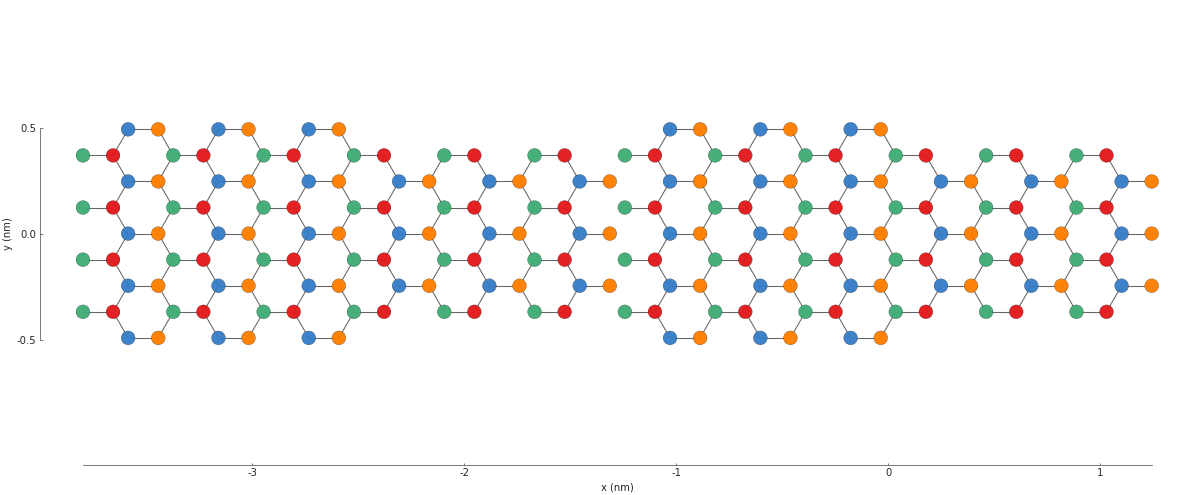

In [116]:
period = 1

plt.figure(figsize=(20.7, 20.6))


## Energy

In [74]:
def mass_termy(V1,w1,w2,w3):
#This function makes potential difference along y axes. And it changes suddenly
    @pb.onsite_energy_modifier

    def potential(energy, sub_id,x,y):
        energy[y>=0] += V1
        energy[y<0] -= V1
        return energy
    
    return potential

In [75]:
def mass_termy_kink(V1,w1,w2,w3):
#This function makes potential difference along y axes. And it changes gradually
    @pb.onsite_energy_modifier
    def potential(energy, sub_id,x,y):
        yrange=w3*3*(w1+w2)*graphene.a_cc/2
        energy[y>=yrange] += V1
        energy[(y<yrange)&(y>=-yrange)] += V1/(yrange)*y[(y<yrange)&(y>=-yrange)]
        energy[y<-yrange] -= V1
        return energy

    return potential

In [76]:
def mass_term_siny(V1,w1,w2,w3):
#potential equals to siny
    @pb.onsite_energy_modifier

    def potential(energy, sub_id,x,y):
        energy += V1*sin(2*pi*y/(3*(w1+w2)*graphene.a_cc))
        return energy
    
    return potential


In [123]:
def energy():
    #w4 is width of none potential changnig direction
    #e1 is magnitute of the potential
    plt.figure(figsize=(20,20))
    
    #normal
    model = pb.Model(lattice, supercell, pb.translational_symmetry(a1=18 ,a2=False))
    
    plt.subplot(231)
    solver = pb.solver.lapack(model)
    eigenvalues = solver.eigenvalues

    a_cc = graphene.a_cc
    Gamma = [-4*math.pi/a/a, 0]
    K1 = [0, 0]
    bands = solver.calc_bands(K1, Gamma)
    bands.plot(point_labels=['K', r'$\Gamma$'])
    plt.ylim(-1,1)


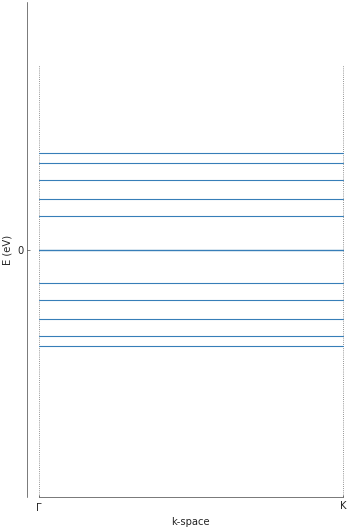

In [124]:
energy()

In [77]:
def zigzag(w1,w2,w3,w4,e1):
    #w1, w2 is width of each area on the potential changing direction
    #w3 is only for kink, it determines the width of gradual changing area
    #w4 is width of none potential changnig direction
    #e1 is magnitute of the potential
    plt.figure(figsize=(20,20))
    
    
    #normal
    model = pb.Model(
        monolayer_4atomy(),
        pb.rectangle(2*w4*graphene.a_cc, 3*(w1+w2)*graphene.a),
        pb.translational_symmetry(a1=w4*graphene.a, a2=3*(w1+w2)*graphene.a_cc),
        mass_termy(e1,w1,w2,w3)
    )
    
    plt.subplot(231)
    solver = pb.solver.lapack(model)
    eigenvalues = solver.eigenvalues

    a_cc = graphene.a_cc
    Gamma = [-4*pi/a/w4, 0]
    K1 = [0, 0]
    bands = solver.calc_bands(K1, Gamma)
    bands.plot(point_labels=['K', r'$\Gamma$'])
    plt.ylim(-1,1)

#    model shape    
    plt.subplot(234)
    model.onsite_map.plot(cmap="coolwarm", site_radius=0.04,num_periods=0)
    pb.pltutils.colorbar(label="U (eV)")
    
    
    #sin
    model = pb.Model(
        monolayer_4atomy(),
        pb.rectangle(2*w4*graphene.a_cc, 3*(w1+w2)*graphene.a),
        pb.translational_symmetry(a1=w4*graphene.a, a2=3*(w1+w2)*graphene.a_cc),
        mass_term_siny(e1,w1,w2,w3)
    )
    
    plt.subplot(232)
    solver = pb.solver.lapack(model)
    eigenvalues = solver.eigenvalues

    a_cc = graphene.a_cc
    Gamma = [-4*pi/a/w4, 0]
    K1 = [0, 0]
    bands = solver.calc_bands(K1, Gamma)
    bands.plot(point_labels=['K', r'$\Gamma$'])
    plt.ylim(-1,1)

#    model shape    
    plt.subplot(235)
    model.onsite_map.plot(cmap="coolwarm", site_radius=0.04,num_periods=0)
    pb.pltutils.colorbar(label="U (eV)")  
    
    #kink
    model = pb.Model(
        monolayer_4atomy(),
        pb.rectangle(2*w4*graphene.a_cc, 3*(w1+w2)*graphene.a),
        pb.translational_symmetry(a1=w4*graphene.a, a2=3*(w1+w2)*graphene.a_cc),
        mass_termy_kink(e1,w1,w2,w3)
    )
    
    plt.subplot(233)
    solver = pb.solver.lapack(model)
    eigenvalues = solver.eigenvalues
    
    
    a_cc = graphene.a_cc
    Gamma = [-4*pi/a/w4, 0]
    K1 = [0, 0]
    bands = solver.calc_bands(K1, Gamma)
    bands.plot(point_labels=['K', r'$\Gamma$'])
    plt.ylim(-1,1)

#    model shape    
    plt.subplot(236)
    model.onsite_map.plot(cmap="coolwarm", site_radius=0.04,num_periods=0)
    pb.pltutils.colorbar(label="U (eV)")

In [79]:

zigzag(2,2,0.5,2,1*0.066*math.pi)

NameError: name 'monolayer_4atomy' is not defined